<a href="https://colab.research.google.com/github/YazidAkmal/Kickstarter-Project-Success-Prediction/blob/main/23_11_5845_UAS_BDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UJIAN AKHIR SEMESTER**

### **MATA KULIAH BIG DATA & PREDICTIVE ANALYTICS LANJUT**


---

Nama  : Yazid Akmal Adyatma

NIM   : 23.11.5845

Kelas : 23 S1IF 06

---

## **Kickstarter Project Success Prediction**

Menggunakan perbandingan antara Logistic Regression vs Random Forest

## **Profile Dataset**

Tautan dataset public: https://www.kaggle.com/datasets/kemical/kickstarter-projects


---

Karakteristik big data (5v) yang dipenuhi:


*   Volume  : Memiliki jumlah data yang besar (323.746 baris data)
*   Variety : Memiliki variabel beragam (teks, numerik, dan kategorikal)
*   Value   : Memprediksi apakah ide bisnis akan didanai atau gagal


### **Setup HDFS**

In [ ]:
from pyspark.sql import SparkSession
import os

spark = (SparkSession.builder
    .appName("Kickstarter_UAS_BDL")
    .master("local[*]")
    .getOrCreate())

OUT_DIR = "output_UAS_BDL"
os.makedirs(OUT_DIR, exist_ok=True)

print("Spark Version:", spark.version)

Spark Version: 4.0.1


### **Load Dataset & Prepocessing Data**

casting tipe data, handling missing value, seleksi kolom, dll

In [ ]:
from pyspark.sql.functions import col, when, regexp_replace

# Load Data
df_raw = spark.read.csv("/content/ks-projects-201612.csv", header=True, inferSchema=False)

# Fix Header Spasi
new_column_names = [c.strip() for c in df_raw.columns]
df_raw = df_raw.toDF(*new_column_names)

# Seleksi Kolom
selected_cols = ["ID", "name", "main_category", "currency", "goal", "state"]
df_selected = df_raw.select(selected_cols)

print("Sampel Data Mentah (Sebelum Filter):")
df_selected.show(5, truncate=False)

# Filter & Cleaning
target_states = ["successful", "failed"]

df_clean = df_selected \
    .filter(col("state").isin(target_states)) \
    .withColumn("goal_clean", regexp_replace(col("goal"), ",", "")) \
    .filter(col("goal_clean").rlike(r"^-?[0-9]*\.?[0-9]+$"))

# Casting
df_clean = df_clean.withColumn("goal", col("goal_clean").cast("double")) \
                   .withColumn("label", when(col("state") == "successful", 1.0).otherwise(0.0))

# Drop Null & Duplicate
df_clean = df_clean.dropna(subset=["main_category", "goal", "label"]) \
                   .dropDuplicates(['ID'])

print(f"Data Bersih: {df_clean.count()} baris")

df_clean.show(5)

Sampel Data Mentah (Sebelum Filter):
+----------+----------------------------------------------------------+-------------+--------+-----+----------+
|ID        |name                                                      |main_category|currency|goal |state     |
+----------+----------------------------------------------------------+-------------+--------+-----+----------+
|1000002330|The Songs of Adelaide & Abullah                           |Publishing   |GBP     |1000 |failed    |
|1000004038|Where is Hank?                                            |Film & Video |USD     |45000|failed    |
|1000007540|ToshiCapital Rekordz Needs Help to Complete Album         |Music        |USD     |5000 |failed    |
|1000011046|Community Film Project: The Art of Neighborhood Filmmaking|Film & Video |USD     |19500|canceled  |
|1000014025|Monarch Espresso Bar                                      |Food         |USD     |50000|successful|
+----------+-------------------------------------------------------

### **Batch Processing dan Partisi RDD**

menggunakan map, reducyByKey, dan repartition

In [ ]:
from operator import add

# Konversi ke RDD
rdd_cat = df_clean.select("main_category").rdd.repartition(4)

# Map & ReduceByKey
category_counts = rdd_cat.map(lambda row: (row['main_category'], 1)) \
                         .reduceByKey(add) \
                         .sortBy(lambda x: -x[1])

print("Top 5 Kategori (MapReduce Result):")
top_categories = category_counts.take(5)
for cat, count in top_categories:
    print(f"{cat}: {count}")

Top 5 Kategori (MapReduce Result):
Film & Video: 50819
Music: 40699
Publishing: 29968
Games: 22373
Art: 21662


### **Manipulasi Data (Query Spark) dan Visualisasi**



+-------------+-------------+----------------+--------+
|main_category|total_project|success_rate_pct|avg_goal|
+-------------+-------------+----------------+--------+
|        Dance|         3167|            65.7|  8276.0|
|      Theater|         9237|            64.3| 22384.0|
|       Comics|         7875|            57.0| 23858.0|
|        Music|        40699|            53.1| 14394.0|
|          Art|        21662|            44.4| 36406.0|
| Film & Video|        50819|            41.9| 68170.0|
|        Games|        22373|            41.9| 44897.0|
|       Design|        19964|            39.8| 44169.0|
|   Publishing|        29968|            34.0| 18559.0|
|  Photography|         8622|            33.5| 11397.0|
+-------------+-------------+----------------+--------+



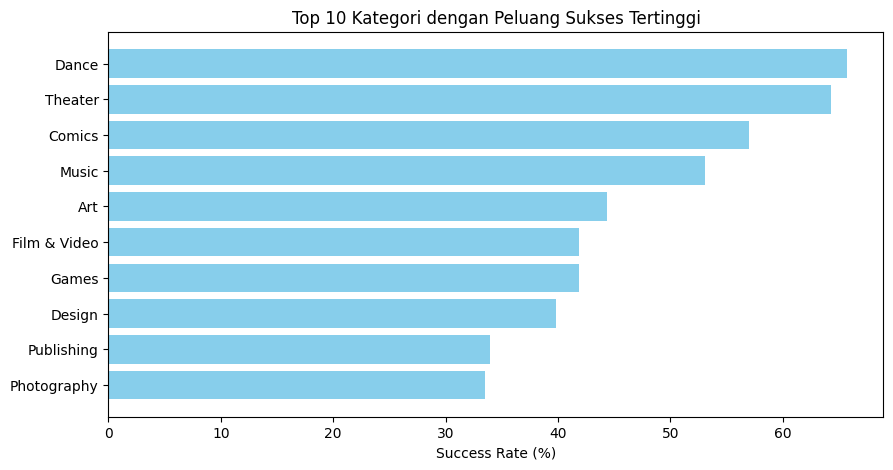

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_clean.createOrReplaceTempView("kickstarter")

sql_query = """
    SELECT main_category,
           COUNT(*) as total_project,
           ROUND(AVG(label) * 100, 1) as success_rate_pct,
           ROUND(AVG(goal), 0) as avg_goal
    FROM kickstarter
    GROUP BY main_category
    HAVING total_project > 1000
    ORDER BY success_rate_pct DESC
    LIMIT 10
"""
df_stats = spark.sql(sql_query)
df_stats.show()

pdf = df_stats.toPandas()

plt.figure(figsize=(10, 5))
plt.barh(pdf['main_category'], pdf['success_rate_pct'], color='skyblue')
plt.xlabel('Success Rate (%)')
plt.title('Top 10 Kategori dengan Peluang Sukses Tertinggi')
plt.gca().invert_yaxis()
plt.show()

### **Feature Engineering Pipeline**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Ubah Kategori jadi Angka
indexer = StringIndexer(inputCol="main_category", outputCol="cat_idx")

# One Hot Encoding
encoder = OneHotEncoder(inputCols=["cat_idx"], outputCols=["cat_vec"])

# Gabung Fitur
assembler = VectorAssembler(inputCols=["cat_vec", "goal"], outputCol="features_raw")

# StandardScaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=False, withStd=True)

### **Modeling**

Komparasi antara 2 algoritma (logistic reg vs random forest)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# Pipeline
pipeline_lr = Pipeline(stages=[indexer, encoder, assembler, scaler, lr])
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler, scaler, rf])

# Split Data
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
print("Data siap dilatih.")

Data siap dilatih.


### **Training Data**

In [ ]:
model_lr = pipeline_lr.fit(train_data)

model_rf = pipeline_rf.fit(train_data)

### **Hyperparameter Tuning**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Cross Validator
cv = CrossValidator(estimator=pipeline_rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

cv_model = cv.fit(train_data)
best_model = cv_model.bestModel

best_rf_stage = best_model.stages[-1]
print(f"Best NumTrees: {best_rf_stage.getNumTrees}")
print(f"Best MaxDepth: {best_rf_stage.getOrDefault('maxDepth')}")

Best NumTrees: 20
Best MaxDepth: 10


### **Evaluasi Model**
Logistic Regression vs Random Forest

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

pred_lr = model_lr.transform(test_data)
pred_rf = best_model.transform(test_data)

eval_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
eval_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

auc_lr = eval_auc.evaluate(pred_lr)
acc_lr = eval_acc.evaluate(pred_lr)
f1_lr  = eval_f1.evaluate(pred_lr)
prec_lr = eval_prec.evaluate(pred_lr)
rec_lr = eval_rec.evaluate(pred_lr)

auc_rf = eval_auc.evaluate(pred_rf)
acc_rf = eval_acc.evaluate(pred_rf)
f1_rf  = eval_f1.evaluate(pred_rf)
prec_rf = eval_prec.evaluate(pred_rf)
rec_rf = eval_rec.evaluate(pred_rf)

print("HASIL EVALUASI LOGISTIC REGRESSION")
print("")
print(f"AUC Score : {auc_lr:.4f}")
print(f"Accuracy  : {acc_lr:.4f}")
print(f"Precision : {prec_lr:.4f}")
print(f"Recall    : {rec_lr:.4f}")
print(f"F1-Score  : {f1_lr:.4f}")
print("")

print("HASIL EVALUASI RANDOM FOREST") # Setelah tuning
print("")
print(f"AUC Score : {auc_rf:.4f}")
print(f"Accuracy  : {acc_rf:.4f}")
print(f"Precision : {prec_rf:.4f}")
print(f"Recall    : {rec_rf:.4f}")
print(f"F1-Score  : {f1_rf:.4f}")

HASIL EVALUASI LOGISTIC REGRESSION

AUC Score : 0.6526
Accuracy  : 0.6292
Precision : 0.6145
Recall    : 0.6292
F1-Score  : 0.5971

HASIL EVALUASI RANDOM FOREST

AUC Score : 0.6623
Accuracy  : 0.6374
Precision : 0.6248
Recall    : 0.6374
F1-Score  : 0.6180


### **Simpan Hasil Model dan Prediksi**

In [ ]:
# Simpan Model Terbaik
model_path = f"{OUT_DIR}/best_kickstarter_model"
best_model.write().overwrite().save(model_path)

# Simpan Prediksi ke Parquet
pred_path = f"{OUT_DIR}/final_predictions.parquet"
pred_rf.select("ID", "name", "state", "goal", "prediction", "probability") \
       .write.mode("overwrite").parquet(pred_path)

print(f"Model tersimpan di: {model_path}")
print(f"Prediksi tersimpan di: {pred_path}")

Model tersimpan di: output_UAS_BDL/best_kickstarter_model
Prediksi tersimpan di: output_UAS_BDL/final_predictions.parquet


### **Kesimpulan**

Program ini telah berhasil mengimplementasikan pipeline bigdata dengan PySpark, mulai dari prepocessing data hingga pembuatan model ML. Hasil perbandingan antara Logistic Regression dengan Random Forest, Randof fores setelah tuning unggul denan nilai AUC sebesar 0.6623 dan F1 Score sebesar 0.618.